<a href="https://colab.research.google.com/github/SanjaySaatyaki/pytorch_4_ml_dl/blob/main/04_pytroch_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Get Data

Food 101's subclass

3 classes.

In [27]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
  print("image path exists")
else:
  print(f"{image_path} does not exists")
  image_path.mkdir(parents=True,exist_ok = True)

with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

image path exists


In [28]:
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
  zip_ref.extractall(image_path)

## Data preparation and Data Exploration

In [29]:
import os
def walk_through_dir(dir_path):
  for dir_path, dir_names, file_names in os.walk(dir_path):
    print(f"There are {len(dir_names)} directories and {len(file_names)} images in {dir_path}")

In [30]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [31]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [32]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualizing a image

In [33]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

In [34]:
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg')]

data/pizza_steak_sushi/test/sushi/479711.jpg
sushi
Random image path: data/pizza_steak_sushi/test/sushi/479711.jpg
Image class: sushi
Image height: 512
Image width: 512


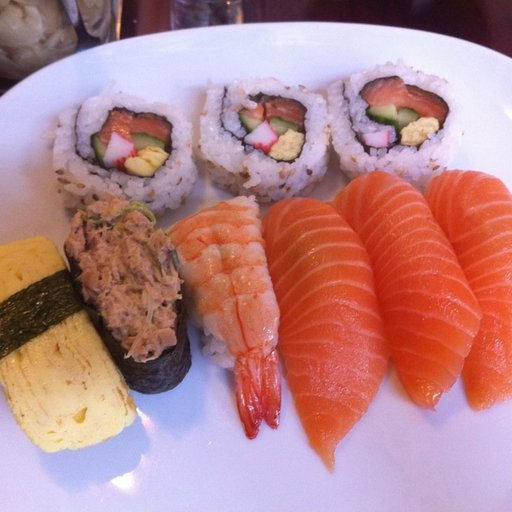

In [35]:
random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Text(0.5, 1.0, 'Image class: sushi| image shape:(512, 512, 3)')

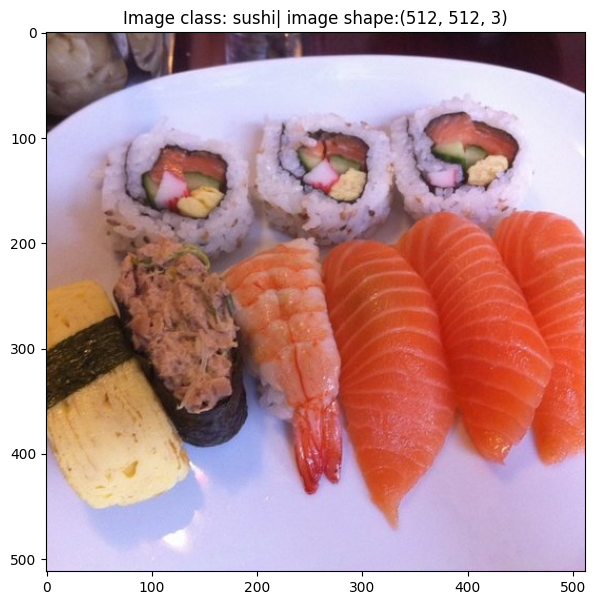

In [36]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}| image shape:{img_as_array.shape}")

In [37]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [38]:
data_transform = transforms.Compose([
    #Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [39]:
data_transform(img).dtype

torch.float32

In [46]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path)as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)


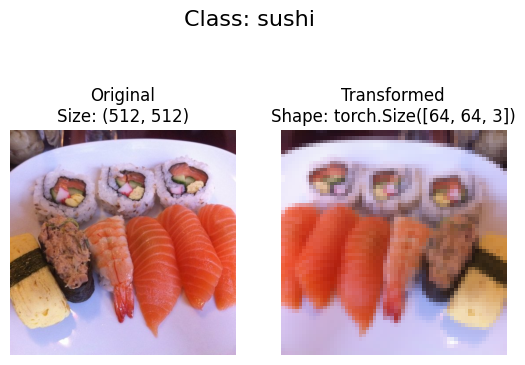

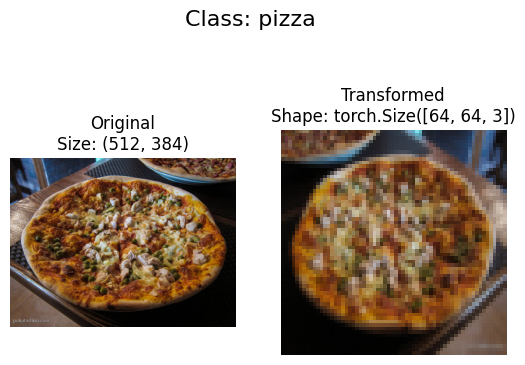

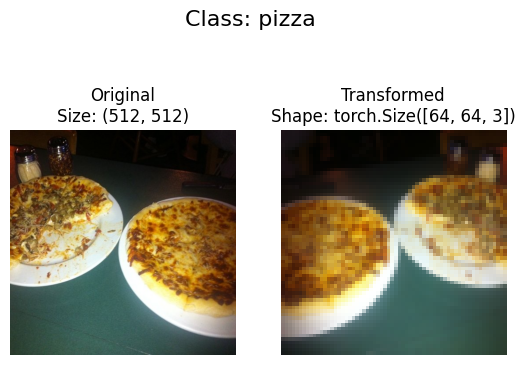

In [47]:
plot_transformed_images(image_paths=image_path_list,transform=data_transform,n=3,seed=42)

In [50]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

In [51]:
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [53]:
class_names = train_data.classes